# Exotica catalog

In [110]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

In [127]:
df = pd.read_csv("../../semiExotica_Catalog_2024-08-14/Catalog_semiExotica_ALL.txt", sep="|")

In [215]:
df[['ra', 'dec']] = df['ra dec J2000'].str.split(' ', expand=True).astype(float)
df.head()

,main name,ra dec J2000,parallax (mas),proper motion (mas/yr),redshift,found in simbad,gaia dr2 id,gaia dr3 id,alternate designations,score,type_catalog,ra,dec
0,G0.0000+0.0000,0.000000 0.000000,NaN,NaN,NaN,N,NaN,NaN,NaN,4096.746964,x:Maser_MDBmas,0.0,0.000000
1,G65.735-75.474,0.000000 -18.691556,NaN,NaN,NaN,N,NaN,NaN,NaN,4096.746964,x:Maser_MDBmas,0.0,-18.691556
2,G105.812-43.807,0.000000 17.348178,NaN,NaN,NaN,N,NaN,NaN,G351.416+0.646,4096.746964,x:Maser_MDBmas,0.0,17.348178
3,G106.566-41.836,0.000000 19.395550,NaN,NaN,NaN,N,NaN,NaN,G049.488-0.387,4096.746964,x:Maser_MDBmas,0.0,19.395550
4,G111.788-24.160,0.000000 37.596056,NaN,NaN,NaN,N,NaN,NaN,NEW3,4096.746964,x:Maser_MDBmas,0.0,37.596056


In [216]:
len(df)

2023793

In [217]:
not_in_dr3 = df[df['gaia dr3 id'].isna()]

In [218]:
len(not_in_dr3)

1279880

In [219]:
# g: Galaxies (~1B stars)
# d: Diffuse subgalactic objects (e.g. star clusters) (~1 star)
# c: galaxy associations (~1B stars)
multiple_stars = not_in_dr3[not_in_dr3['type_catalog'].str.startswith(('g:', 'c:'))]

In [220]:
len(multiple_stars)

701170

In [221]:
# data = multiple_stars[~multiple_stars['parallax (mas)'].isna()]

In [222]:
data = multiple_stars[~multiple_stars['redshift'].isna()]

In [223]:
len(data)

188690

In [224]:
cats = []
for el in data['type_catalog'].str.split("_"):
    for i in range(1, len(el), 2):
        cats.append(el[i].split(";")[0])
from collections import Counter
Counter(cats)

Counter({'PGCgal': 171514,
         'V10agn': 13108,
         'A89gcl': 2271,
         'K14vir': 1108,
         'B85vir': 559,
         'A22grs': 268,
         'F89for': 233,
         'V18for': 177,
         'K13gal': 157,
         'S03irg': 90,
         'C09bcg': 71,
         'O18xrs': 50,
         'V12rad': 34,
         'V99xrs': 33,
         'V17for': 12,
         'H24opc': 4,
         'MDBmas': 3,
         'G12glb': 2,
         'S17var': 2,
         'C22fgl': 1,
         'B08mag': 1,
         'P16vgl': 1,
         'A19sym': 1})

In [225]:
data.head(2)

,main name,ra dec J2000,parallax (mas),proper motion (mas/yr),redshift,found in simbad,gaia dr2 id,gaia dr3 id,alternate designations,score,type_catalog,ra,dec
13,LEDA 2794824,0.000833 -40.113333,NaN,NaN,0.095331,Y,NaN,NaN,PGC2794824,2.039544,g:Galaxy_PGCgal,0.000833,-40.113333
17,LEDA 402770,0.001625 -56.141056,NaN,NaN,0.010100,Y,NaN,NaN,PGC0402770,2.039544,g:Galaxy_PGCgal,0.001625,-56.141056


In [226]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

@np.vectorize
def calc_distance_redshift(z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.comoving_distance(z).value

In [227]:
calc_distance_redshift(data["redshift"].to_numpy()[:5])

array([399.36078953,  43.15725765, 210.02972519, 555.39916595,
       771.18646199])

In [305]:
from targetexplore import random_pointings
centers = random_pointings(
    30000, # CORRECT ONE 
    # 5, # LOWER FOR TESTING
    dec_lims=[-90, 45]
)

In [306]:
mask = np.zeros_like(data['ra'], dtype=bool)
coords = SkyCoord(ra=data['ra'].values*u.deg, dec=data['dec'].values*u.deg)
for center in centers:
    sep = center.separation(coords)
    mask |= sep < 6 * u.arcmin
filtered_data = data[mask]

In [307]:
filtered_data[['main name', 'redshift', 'parallax (mas)', 'ra', 'dec']].to_numpy()

array([['2dFGRS TGS276Z139', 0.0758, nan, 0.120417, -29.105278],
       ['ESO 293-28', 0.051404, nan, 0.145417, -40.576389],
       ['2dFGRS TGS276Z133', 0.0705, nan, 0.281326, -29.02167],
       ...,
       ['2dFGRS TGS277Z219', 0.0997, nan, 359.933333, -29.058889],
       ['2dFGRS TGS276Z143', 0.0619, nan, 359.962045, -29.087591],
       ['LEDA 107678', 0.058367, nan, 359.990792, -38.271056]],
      shape=(4741, 5), dtype=object)

In [309]:
dists = calc_distance_redshift(filtered_data["redshift"].to_numpy())

In [311]:
### COPIED FROM EIRP - TFM

In [312]:
import numpy as np
from astropy import units as u

In [313]:
hi, lo = 15.3 * u.GHz, 8.4 * u.GHz
bandwidth = 2 * u.GHz
nu_mean = (hi + lo)/2
nu_rel = bandwidth / nu_mean

In [314]:
T_rx = lambda nu: 10.6*u.K + 0.633 * (nu - 8.41*u.GHz) * (u.K/u.GHz)
T_sky = lambda nu: 568*u.K * (nu / u.GHz)**-1.13 # galactic center 
T_sys = lambda nu: T_rx(nu) + T_sky(nu)

In [351]:
S_N_min = 10 # Czech et al. (2021), Price et al. (2020)
k_B = 1.3806503e-23 * (u.J / u.K) # Boltzmann Constant
D = 13.5 * u.m # antenna diameter
# D = 8 * u.km # antenna syntetized beam
n_antennas = 64
A_eff = .65 * np.pi * (D / 2)**2 / n_antennas
B = 1 * u.Hz # width of the signal
n_pol = 1
tau_obs = 30 * 60 * u.s # 30 minutes

In [352]:
F_min = lambda nu: S_N_min * 2 * k_B * T_sys(nu) / A_eff * np.sqrt(B / (n_pol * tau_obs))

In [353]:
F_min(10 * u.GHz).to(u.W / (u.m)**2)

<Quantity 2.40472361e-22 W / m2>

In [354]:
EIRP_min = lambda nu, d: 4 * np.pi * d**2 * F_min(nu)

In [355]:
exotica_eirp_mins = np.array([EIRP_min(nu_mean, d*u.Mpc).to(u.W).value for d in dists])

In [356]:
exotica_counts = Counter(np.ceil(np.log10(exotica_eirp_mins)).astype(int))
x = np.arange(11, 40)
y_exotica_MeerKAT_5b = [np.log10(1 / (nu_rel * exotica_counts[k] * 1e9)) for k in x]
[o.value for o in y_exotica_MeerKAT_5b]

/home/obs/kperez/tmp/ipykernel_22267/1751952862.py:1: RuntimeWarning: divide by zero encountered in log10
  exotica_counts = Counter(np.ceil(np.log10(exotica_eirp_mins)).astype(int))
/home/obs/kperez/tmp/ipykernel_22267/1751952862.py:1: RuntimeWarning: invalid value encountered in cast
  exotica_counts = Counter(np.ceil(np.log10(exotica_eirp_mins)).astype(int))


[np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(-8.70443290003752),
 np.float64(-9.181554154757183),
 np.float64(-9.130401632309802),
 np.float64(-9.926281649653877),
 np.float64(-10.614701471656588),
 np.float64(-11.310814265148126),
 np.float64(-11.629400995889956),
 np.float64(-10.86480137483037),
 np.float64(-10.61112701129829),
 np.float64(-9.306492891365483),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf)]

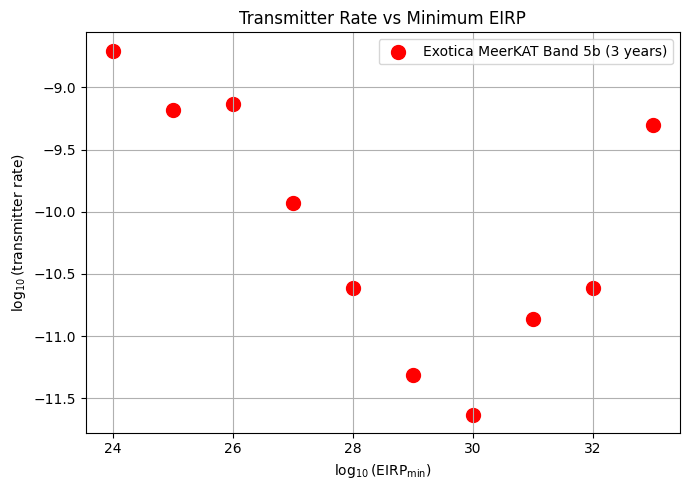

In [357]:
from matplotlib import pyplot as plt
# Plot
plt.figure(figsize=(7,5))
plt.scatter(x, y_exotica_MeerKAT_5b, color='red', s=100, label="Exotica MeerKAT Band 5b (3 years)")
plt.xlabel(r'$\log_{10}(\mathrm{EIRP}_{\min})$')
plt.ylabel(r'$\log_{10}(\mathrm{transmitter\ rate})$')
plt.title('Transmitter Rate vs Minimum EIRP')
plt.grid(True)

plt.legend()
plt.tight_layout()